In [1]:
import pickle
from os.path import join
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

In [2]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
tmp_dir = join(result_dir,'tmp')
res = pd.DataFrame()
for f in glob(join(tmp_dir, '*')):
    with open(f, 'rb') as f:
        df = pickle.load(f)
    res = pd.concat([res, df])

with open(join(result_dir, 'windv2.pkl'), 'wb') as f:
    pickle.dump(res, f)

In [3]:
result_dir = '/bsuscratch/zacharykeskinen/data/infrasound/wind_results'
with open(join(result_dir, 'windv2.pkl'), 'rb') as f:
    wind = pickle.load(f)

In [4]:
wind[['fs','powers']] = pd.DataFrame(wind['power'].tolist(), index=wind.index)
# wind = wind.loc[wind.cor < 0.9]
wind = wind.drop(['power'], axis = 1)
powers = pd.DataFrame(wind['powers'].tolist(), index=wind.index, columns = wind.iloc[0]['fs'])
powers[['sd_delta','cor','wind']] = wind[['sd_delta','cor','wind']]
#powers.loc[powers.sd_delta < -0.5, 'sd_delta'] = -0.5
plot = powers.drop(['cor','wind'], axis= 1).groupby('sd_delta').mean()

Text(0, 0.5, 'Frequency (Hz)')

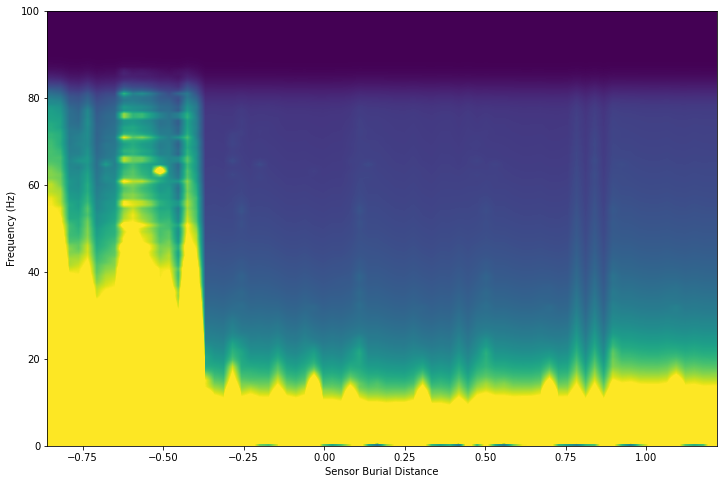

In [5]:
from matplotlib.colors import LogNorm
f, ax = plt.subplots(figsize= (12,8))
# cmap = norm=LogNorm(vmin=0.00000007, vmax=0.000001)
plt.imshow(plot.T.iloc[::-1], vmax = 0.0000005, extent = (plot.index[0], plot.index[-1], plot.columns[0], plot.columns[-1]), aspect = 'auto', interpolation = 'bilinear')
plt.xlabel('Sensor Burial Distance')
plt.ylabel('Frequency (Hz)')